In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import os
from tqdm import tqdm
from pathlib import Path
from skimage.feature import hog
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

base_path = Path("garbage_classification")
clases = os.listdir(base_path)
clase_elegida = random.choice(clases)
imagenes = os.listdir(os.path.join(base_path, clase_elegida))
imagen_elegida = random.choice(imagenes)
ruta_imagen = os.path.join(base_path, clase_elegida, imagen_elegida)

In [2]:
# Preprocesamiento con OpenCV
# Leer imagen en color y en escala de grises
imagen_color = cv2.imread(ruta_imagen)
imagen_rgb = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)
imagen_gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)

# Preprocesamiento con OpenCV
#  filtros convolucionales: Suavizado (filtro Gaussiano)
suavizada = cv2.GaussianBlur(imagen_gris, (5, 5), 0)

# Detección de bordes (Canny)
bordes = cv2.Canny(suavizada, 50, 150)

# Umbralización
_, umbral = cv2.threshold(imagen_gris, 127, 255, cv2.THRESH_BINARY)

# Operaciones morfologicas
kernel = np.ones((5, 5), np.uint8)
erosionada = cv2.erode(umbral, kernel, iterations=1)
dilatada = cv2.dilate(umbral, kernel, iterations=1)
apertura = cv2.morphologyEx(umbral, cv2.MORPH_OPEN, kernel)
cierre = cv2.morphologyEx(umbral, cv2.MORPH_CLOSE, kernel)

In [3]:
# Lista para almacenar vectores de características
datos = []

# Recorremos todas las imágenes y extraemos características
for clase in tqdm(os.listdir(base_path)):
  carpeta = base_path / clase
  if carpeta.is_dir():
    for img_path in carpeta.glob("*.jpg"):
      try:
        # Leer imagen en escala de grises
        img = cv2.imread(str(img_path), 0)
        img = cv2.resize(img, (128, 128))

        # ========== HOG ==========
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=False, feature_vector=True)

        # ========== Hu Moments ==========
        momentos = cv2.moments(img)
        hu_moments = cv2.HuMoments(momentos).flatten()
        
        # ========== Histograma ==========
        histograma = cv2.calcHist([img], [0], None, [64], [0, 256]).flatten()
        histograma = histograma / np.sum(histograma)  # normalización

        # Unir todos los vectores
        caracteristicas = np.concatenate([hog_features, hu_moments, histograma])
        datos.append({
            "ruta": str(img_path),
            "clase": clase,
            "vector": caracteristicas
        })

      except Exception as e:
        print(f"Error procesando {img_path}: {e}")

# Crear DataFrame final
df_vectores = pd.DataFrame(datos)

# DataFrame de vectores
df_vectores = pd.DataFrame(datos)
X = pd.DataFrame(df_vectores["vector"].to_list())

# Normalización
scaler = MinMaxScaler()
X_normalizado = scaler.fit_transform(X)

# Unión con etiquetas
df_final = pd.concat([df_vectores[["ruta", "clase"]].reset_index(drop=True),
                      pd.DataFrame(X_normalizado, columns=[f"f{i}" for i in range(X.shape[1])])], axis=1)

# Mostrar tabla
df_final.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:50<00:00,  7.19s/it]


,ruta,clase,f0,f1,f2,f3,f4,f5,f6,f7,...,f8161,f8162,f8163,f8164,f8165,f8166,f8167,f8168,f8169,f8170
0,garbage_classification\cardboard\cardboard1.jpg,cardboard,0.233598,0.043127,0.026133,0.092996,0.156794,0.077562,0.172895,0.270168,...,0.000188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,garbage_classification\cardboard\cardboard10.jpg,cardboard,0.482301,0.000000,0.487131,0.357266,0.483751,0.254080,0.141970,0.000000,...,0.062852,0.050428,0.028068,0.057816,0.066255,0.160666,0.138317,0.008567,0.000271,0.000000
2,garbage_classification\cardboard\cardboard100.jpg,cardboard,0.415671,0.275614,0.094140,0.061264,0.336096,0.071081,0.089862,0.258350,...,0.006191,0.005867,0.001835,0.003052,0.001840,0.001692,0.001154,0.001168,0.001353,0.001122
3,garbage_classification\cardboard\cardboard11.jpg,cardboard,0.439066,0.101715,0.246537,0.623578,0.440386,0.000000,0.269442,0.142008,...,0.048593,0.062004,0.037700,0.061377,0.042592,0.034878,0.088884,0.123345,0.000271,0.000000
4,garbage_classification\cardboard\cardboard12.jpg,cardboard,0.438318,0.177971,0.107841,0.197729,0.439636,0.000000,0.157147,0.000000,...,0.143902,0.156042,0.098239,0.197185,0.132510,0.103601,0.003870,0.000097,0.000000,0.000000


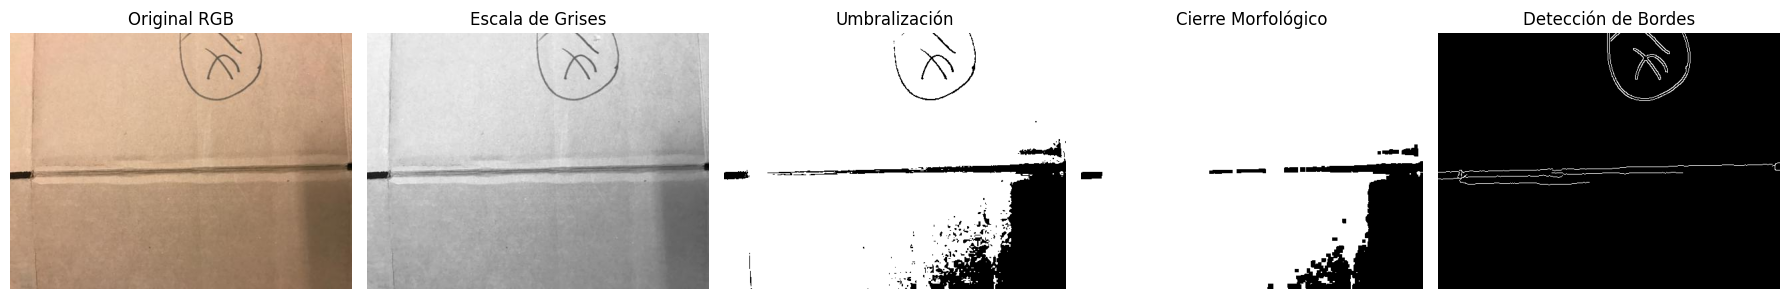

In [4]:
import matplotlib.pyplot as plt

# Visualización de ejemplo para una imagen con preprocesamiento completo
ejemplo = df_final.iloc[0]
imagen_path = ejemplo["ruta"]
imagen_color = cv2.imread(imagen_path)
imagen_rgb = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)
imagen_gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)
_, umbral = cv2.threshold(imagen_gris, 127, 255, cv2.THRESH_BINARY)
kernel = np.ones((5, 5), np.uint8)
cierre = cv2.morphologyEx(umbral, cv2.MORPH_CLOSE, kernel)
suavizada = cv2.GaussianBlur(imagen_gris, (5, 5), 0)
bordes = cv2.Canny(suavizada, 50, 150)

# Mostrar las etapas visuales
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
axs[0].imshow(imagen_rgb)
axs[0].set_title("Original RGB")
axs[1].imshow(imagen_gris, cmap='gray')
axs[1].set_title("Escala de Grises")
axs[2].imshow(umbral, cmap='gray')
axs[2].set_title("Umbralización")
axs[3].imshow(cierre, cmap='gray')
axs[3].set_title("Cierre Morfológico")
axs[4].imshow(bordes, cmap='gray')
axs[4].set_title("Detección de Bordes")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Guardar CSV final con características normalizadas y etiquetas
csv_path = "caracteristicas_normalizadas.csv"
df_final.to_csv(csv_path, index=False)
df_final.head()

,ruta,clase,f0,f1,f2,f3,f4,f5,f6,f7,...,f8161,f8162,f8163,f8164,f8165,f8166,f8167,f8168,f8169,f8170
0,garbage_classification\cardboard\cardboard1.jpg,cardboard,0.233598,0.043127,0.026133,0.092996,0.156794,0.077562,0.172895,0.270168,...,0.000188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,garbage_classification\cardboard\cardboard10.jpg,cardboard,0.482301,0.000000,0.487131,0.357266,0.483751,0.254080,0.141970,0.000000,...,0.062852,0.050428,0.028068,0.057816,0.066255,0.160666,0.138317,0.008567,0.000271,0.000000
2,garbage_classification\cardboard\cardboard100.jpg,cardboard,0.415671,0.275614,0.094140,0.061264,0.336096,0.071081,0.089862,0.258350,...,0.006191,0.005867,0.001835,0.003052,0.001840,0.001692,0.001154,0.001168,0.001353,0.001122
3,garbage_classification\cardboard\cardboard11.jpg,cardboard,0.439066,0.101715,0.246537,0.623578,0.440386,0.000000,0.269442,0.142008,...,0.048593,0.062004,0.037700,0.061377,0.042592,0.034878,0.088884,0.123345,0.000271,0.000000
4,garbage_classification\cardboard\cardboard12.jpg,cardboard,0.438318,0.177971,0.107841,0.197729,0.439636,0.000000,0.157147,0.000000,...,0.143902,0.156042,0.098239,0.197185,0.132510,0.103601,0.003870,0.000097,0.000000,0.000000


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Separar features y etiquetas
X = df_final.drop(columns=["ruta", "clase"])
y = df_final["clase"]

# División entrenamiento/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modelo SVM
modelo_svm = SVC(kernel='rbf', C=10, gamma='scale')
modelo_svm.fit(X_train, y_train)

# Evaluación
y_pred = modelo_svm.predict(X_test)
print("🔍 Clasificación SVM:")
print(classification_report(y_test, y_pred))
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))


🔍 Clasificación SVM:
              precision    recall  f1-score   support

   cardboard       0.54      0.35      0.42        20
 green-glass       0.50      0.60      0.55        40
       metal       0.47      0.40      0.43        40
       paper       0.64      0.77      0.70        60
     plastic       0.45      0.45      0.45        40
       trash       0.70      0.70      0.70        40
 white-glass       0.52      0.42      0.47        40

    accuracy                           0.56       280
   macro avg       0.54      0.53      0.53       280
weighted avg       0.55      0.56      0.55       280

🎯 Accuracy: 0.5571428571428572


In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Ruta a las carpetas (estructura: una carpeta por clase)
ruta_dataset = "garbage_classification"

# Transformaciones: resize, escala [0,1], grayscale, tensor
transformaciones = transforms.Compose([
    transforms.Grayscale(),              # Escala de grises
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Dataset
dataset = datasets.ImageFolder(root=ruta_dataset, transform=transformaciones)

# División en entrenamiento y validación
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CNNBasura(nn.Module):
    def __init__(self, num_clases):
        super(CNNBasura, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_clases)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128 -> 64
        x = self.pool(F.relu(self.conv2(x)))  # 64 -> 32
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo = CNNBasura(num_clases=len(dataset.classes)).to(device)
criterio = nn.CrossEntropyLoss()
optimizador = optim.Adam(modelo.parameters(), lr=0.001)

# Bucle de entrenamiento
for epoch in range(2):  # Recorrer el conjunto de datos varias veces
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # Poner a cero los gradientes de los parámetros
        optimizador.zero_grad()

        # Paso hacia adelante
        outputs = modelo(inputs)
        loss = criterio(outputs, labels)
        # Paso hacia atrás y optimizar
        loss.backward()
        optimizador.step()

        # Imprimir estadísticas
        running_loss += loss.item()
    print(f"Época {epoch+1}, pérdida: {running_loss/len(train_loader):.4f}")


print('Terminó el entrenamiento')

Época 1, pérdida: 2.0496
Época 2, pérdida: 1.4743
Terminó el entrenamiento


In [10]:
modelo.eval()
correctos = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = modelo(inputs)
        _, predicciones = torch.max(outputs, 1)
        correctos += (predicciones == labels).sum().item()
        total += labels.size(0)

print(f"🎯 Precisión en validación: {100 * correctos / total:.2f}%")


🎯 Precisión en validación: 54.29%


 Evaluación del modelo clásico:
              precision    recall  f1-score   support

   cardboard       0.54      0.35      0.42        20
 green-glass       0.50      0.60      0.55        40
       metal       0.47      0.40      0.43        40
       paper       0.64      0.77      0.70        60
     plastic       0.45      0.45      0.45        40
       trash       0.70      0.70      0.70        40
 white-glass       0.52      0.42      0.47        40

    accuracy                           0.56       280
   macro avg       0.54      0.53      0.53       280
weighted avg       0.55      0.56      0.55       280



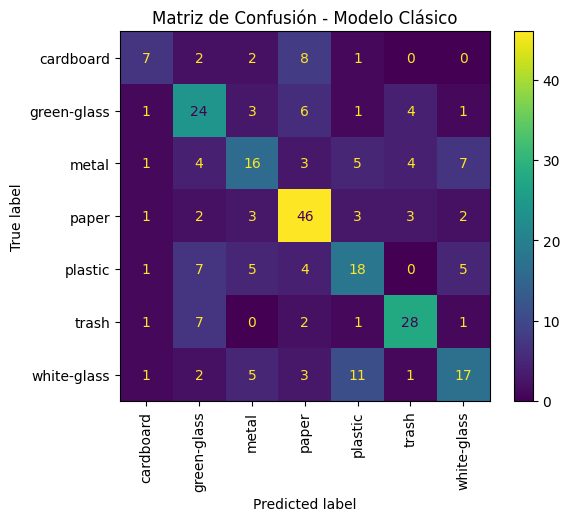

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Reporte
print(" Evaluación del modelo clásico:")
print(classification_report(y_test, y_pred, zero_division=0))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=modelo_svm.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=modelo_svm.classes_)
disp.plot(xticks_rotation=90)
plt.title("Matriz de Confusión - Modelo Clásico")
plt.show()


 Evaluación del modelo CNN:
              precision    recall  f1-score   support

   cardboard       0.36      0.31      0.33        16
 green-glass       0.53      0.49      0.51        41
       metal       0.35      0.55      0.43        44
       paper       0.68      0.89      0.77        64
     plastic       0.67      0.20      0.30        41
       trash       0.95      0.53      0.68        38
 white-glass       0.42      0.50      0.46        36

    accuracy                           0.54       280
   macro avg       0.56      0.49      0.50       280
weighted avg       0.59      0.54      0.53       280



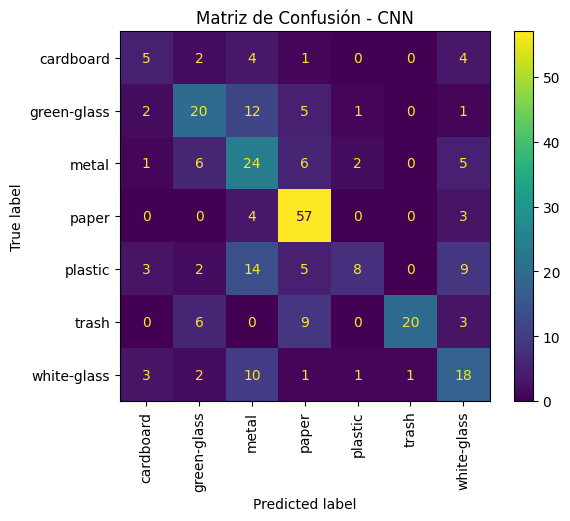

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = modelo(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Reporte
print(" Evaluación del modelo CNN:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(xticks_rotation=90)
plt.title("Matriz de Confusión - CNN")
plt.show()